# 02a HSC ct repl1 preprocessing

Run with this command in docker container

docker run 
--rm 
-d 
--name demuxEM 
-p 8881:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
pegasuspy_scanpy:vs1


followed the workflow in this jupyter notebook: 
(https://github.com/theislab/scanpy-tutorials/blob/master/pbmc3k.ipynb)
updated with the new preprocessing from the female cell regression.

## 1) Loading packages + data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scanpy.external as sce

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)
# plt.rcParams['figure.figsize']=(5,5) #rescale figures

In [4]:
adata = sc.read_10x_mtx(
    './raw_data/LT-HSC_Nr4a1-gfp/outs/filtered_gene_bc_matrices_mex/mm10/', var_names='gene_symbols', cache=True)

... reading from cache file cache/raw_data-LT-HSC_Nr4a1-gfp-outs-filtered_gene_bc_matrices_mex-mm10-matrix.h5ad


In [5]:
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 2912 × 27999 
    var: 'gene_ids'

## 2) Preprocessing  

simple preprocessing recipe adapted from the scanpy tutorial

In [7]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# create metacolums in adata.obs for percentage mitochondrial counts and total counts/gene
mito_genes = adata.var_names.str.startswith('mt-')
# replaced the "MT" with small caps "mt" otherwise couldn't be found
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

from scipy.sparse import issparse #needed for the sparse matrix

# version for sparse matrix
if issparse(adata.X): 
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1      
    
# version for non-sparse matrix
else:
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1)

# Filter cells that exceed 2500 counts (doublets) and have more than 5% mitochondrial counts (dead)
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

sc.pp.filter_genes(adata, min_counts=1) # drop genes that have less than one count

filtered out 1 cells that have less than 200 genes expressed
filtered out 13512 genes that are detected in less than 3 cells
filtered out 90 genes that are detected in less than 1 counts


Trying to set attribute `.var` of view, copying.


In [8]:
# filtered out some cells that were myeloid and endothelial contamination

# got the cell IDs from clustering from a previous sheet. 
c4_cellindex = ['CATATTCTCGGCTACG-1',
 'GCATACACAATGTTGC-1',
 'GCTTCCATCAGAGCTT-1',
 'TAGACCAAGCCCAATT-1',
 'TGCGTGGGTCTAGCCG-1',
 'TGTGTTTTCACAGGCC-1',
 'GCAGCCAAGATATACG-1',
 'CCTACACAGACTAGAT-1',
 'CCGTACTGTCTCAACA-1',
 'CCTTCGAAGCCTCGTG-1',
 'ATGGGAGGTTGCCTCT-1',
 'CACACCTAGTGGGCTA-1',
 'GCGCCAAAGATGCGAC-1',
 'GCACTCTTCAACGGGA-1',
 'ACGATACAGCCTCGTG-1',
 'GCCTCTAAGGACGAAA-1',
 'CACACAAGTCCTCTTG-1',
 'CAGCGACAGGACTGGT-1',
 'GGGAATGCAAGCGCTC-1',
 'TAGTTGGCACCAACCG-1']


filtered_cells = list(set(list(adata.obs_names)) - set(c4_cellindex))
adata = adata[filtered_cells, :]

In [9]:
# normalize to 10K counts/cell and logtransform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## 3) Select variable genes for downstream analysis

In [10]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [11]:
# number of variable genes
np.sum(adata.var['highly_variable'])

1275

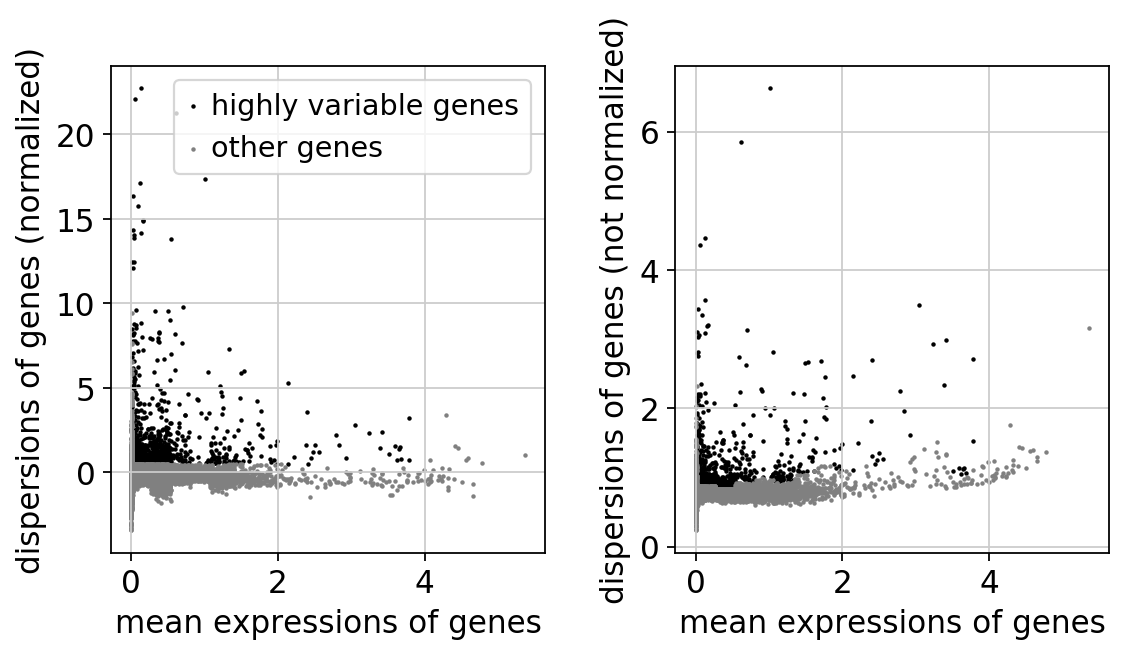

In [12]:
sc.pl.highly_variable_genes(adata)

In [13]:
adata = adata[:, adata.var['highly_variable']]

In [14]:
adata #this now only contains the most variable genes

View of AnnData object with n_obs × n_vars = 2382 × 1275 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## 4) Regress out female cells + scale

I will used the gene Xist for identifying female cells. Xist is a long non coding RNA that is expressed in all cells to silence one of the two X chromosomes in female cells.
More information on Xist: https://en.wikipedia.org/wiki/XIST

(array([1.197e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.400e+01,
        2.000e+01, 2.000e+01, 1.700e+01, 8.000e+00, 5.000e+00, 5.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 7.000e+00,
        6.000e+00, 7.000e+00, 1.600e+01, 2.800e+01, 2.700e+01, 2.400e+01,
        3.600e+01, 3.200e+01, 5.200e+01, 5.400e+01, 7.400e+01, 8.200e+01,
        7.900e+01, 8.000e+01, 9.100e+01, 1.030e+02, 8.300e+01, 7.300e+01,
        5.200e+01, 3.800e+01, 2.000e+01, 1.200e+01, 5.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.        , 0.0831161 , 0.1662322 , 0.24934831, 0.3324644 ,
        0.4155805 , 0.49869663, 0.58181274, 0.6649288 , 0.7480449 ,
        0.831161  , 0.91427714, 0.99739325, 1.0805093 , 1.1636255 ,
        1.2467415 , 1.3298576 , 1.4129738 , 1.4960898 , 1.579206  ,
        1.662322  , 1.7454381 , 1.8285543 , 1.9116703 , 1.9947865 ,
        2.0779026 , 2.1610186 , 2.24

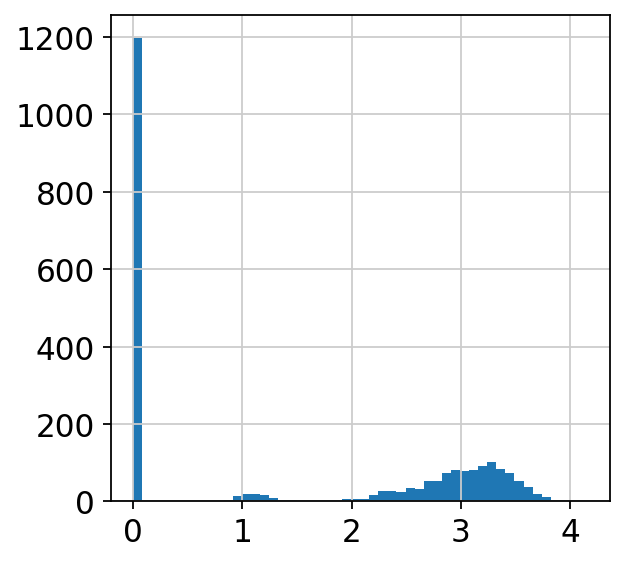

In [15]:
plt.hist(adata[: , 'Xist'].X.toarray(), bins=50)

In [16]:
adata.obs['Female'] = adata[: , 'Xist'].X.toarray() > 0 # make a column in adata.obs to identify female cells
adata.obs['rXist'] = adata.raw[: , 'Xist'].X.toarray() + 0.01 # make a column in adata.obs that stores the actual values of Xist, add 0.01 to get rid of "0" for downstream processin 
adata.obs['Female_cat']=adata.obs['Female'].astype('category', copy=True) # make a column with category as dtype

Trying to set attribute `.obs` of view, copying.


In [17]:
#regresses out Xist from adata 
sc.pp.regress_out(adata, ['rXist'])

regressing out ['rXist']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


    finished (0:00:04)


In [18]:
sc.pp.scale(adata, max_value=10)

## 5) PCA

Compute PCA and make a scatter plot.

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


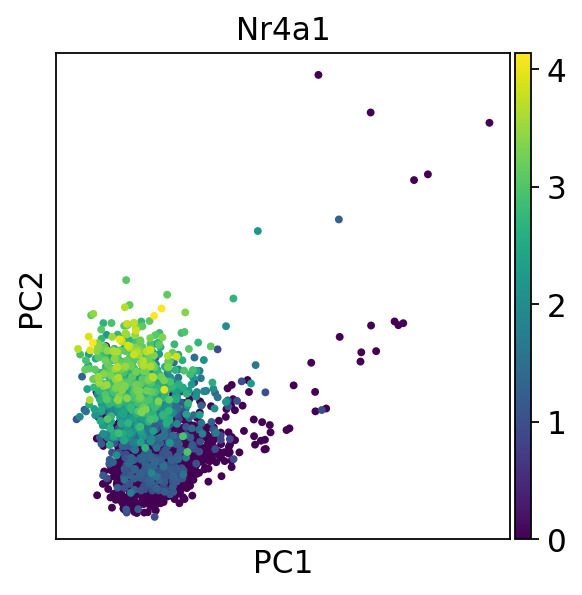

In [20]:
sc.pl.pca(adata, color='Nr4a1')

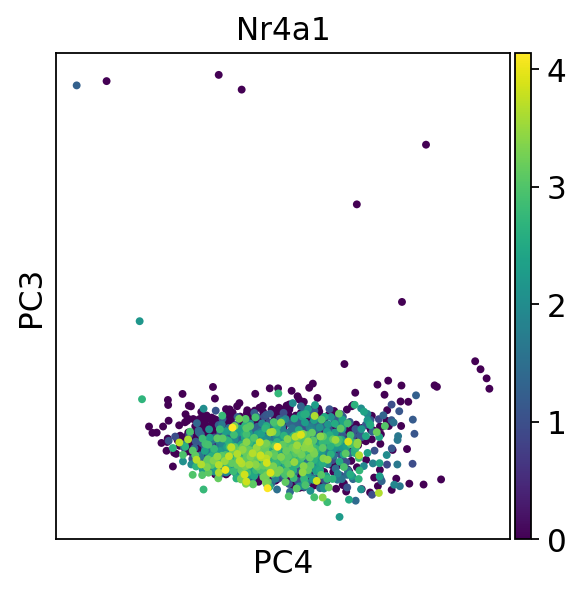

In [21]:
sc.pl.pca(adata, color='Nr4a1', components='4,3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

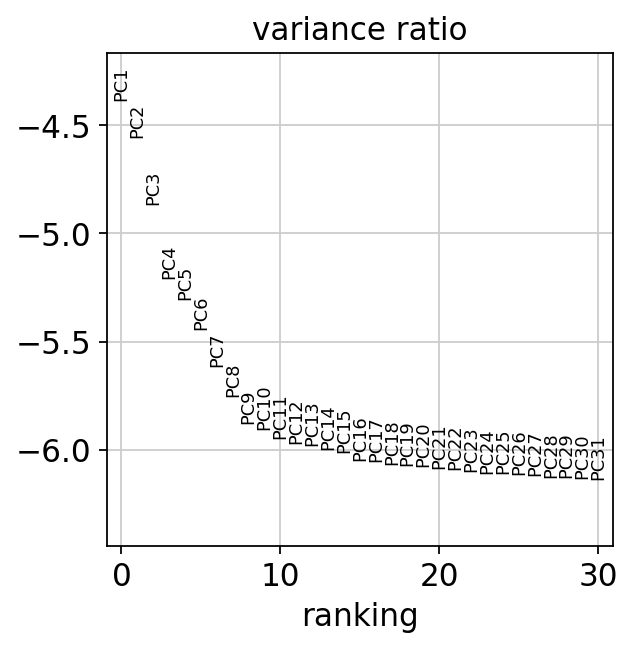

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

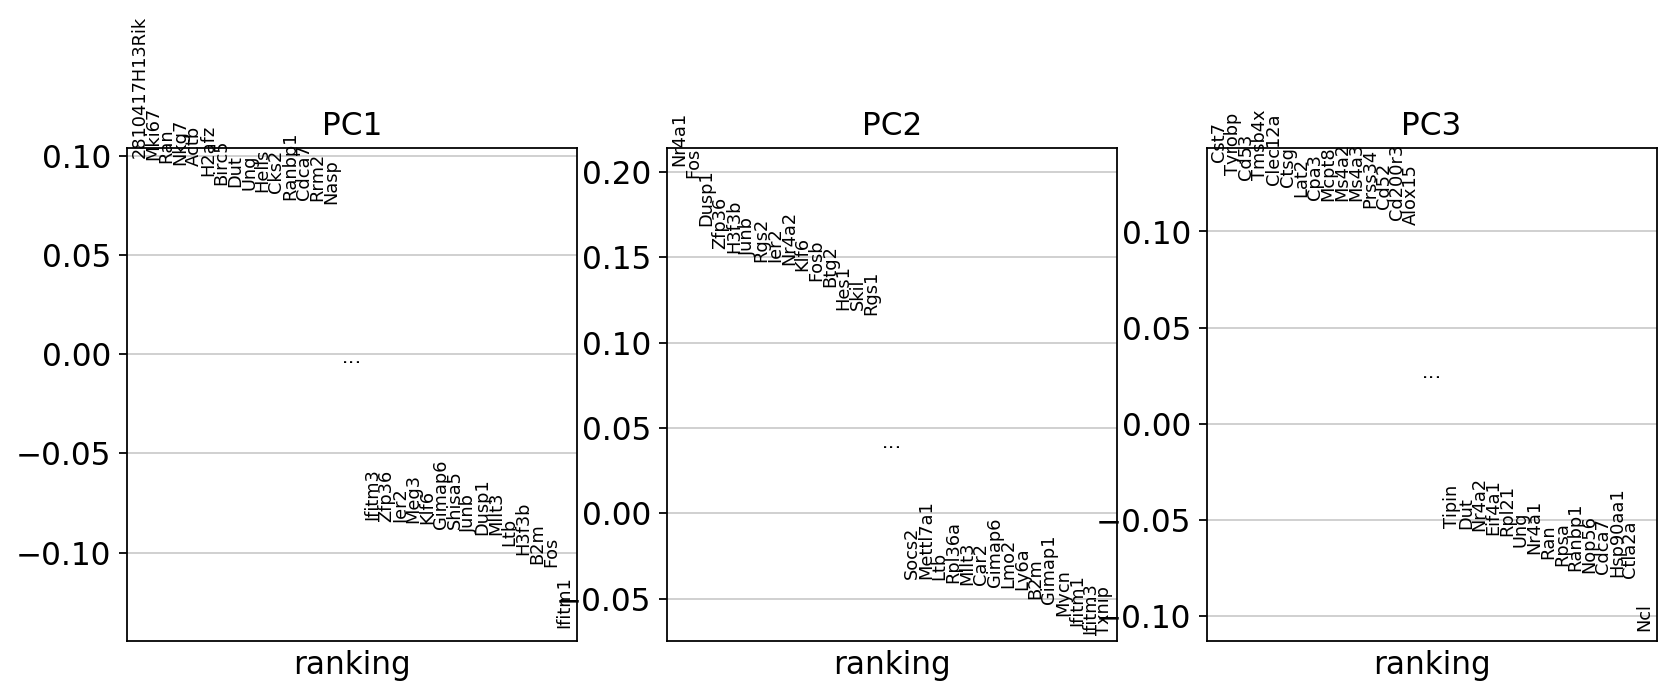

In [23]:
sc.pl.pca_loadings(adata)

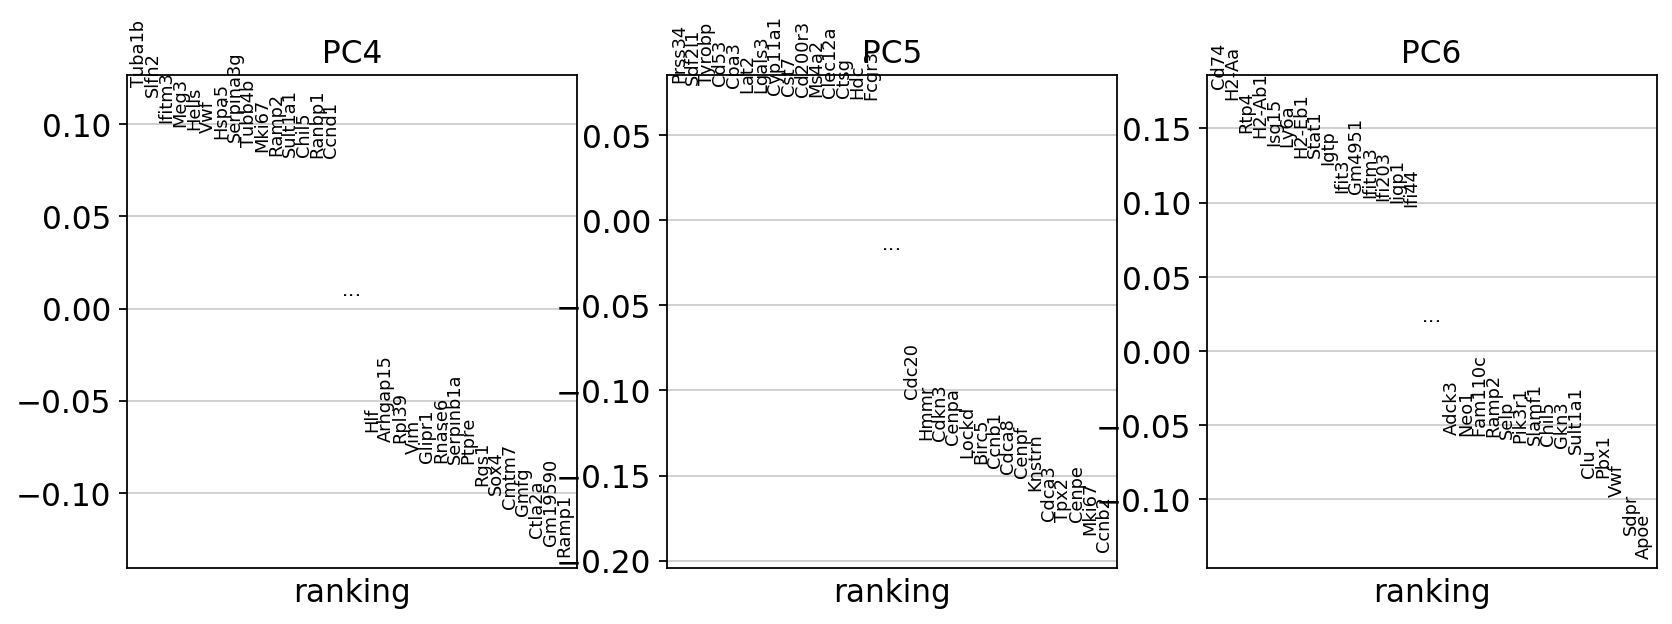

In [24]:
list_pcs= [4,5,6]
sc.pl.pca_loadings(adata, components= list_pcs)

In [25]:
adata

AnnData object with n_obs × n_vars = 2382 × 1275 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'Female', 'rXist', 'Female_cat'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 6) Calculate best neigborhood and cluster combination - Leiden

Compute the best clustering outcomes using Silhouette and Davies Boulding scores

In [26]:
## make loop to save different silhouette scores and Davies Bouldin scores in a dataframe

from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from tqdm import tnrange, tqdm_notebook
from time import sleep
import warnings


sc.settings.verbosity = 0   ### suppress output of scanpy
warnings.filterwarnings('ignore') # suppress Warnings
results_df=[]
results_df = pd.DataFrame(columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould'])

for k in tnrange(5, 50, 5, desc ='1st loop'):
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=40);
    sc.tl.umap(adata);
    
    for i in tqdm_notebook(range(40, 150, 10), desc ='2nd loop', leave=False):
        j = i/100
        sc.tl.leiden(adata, resolution=j);
        sc.tl.rank_genes_groups(adata, 'leiden')
        silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden'])
        davies_bouldin_avg = davies_bouldin_score(adata.obsm['X_pca'], adata.obs['leiden'])
        results_df = results_df.append(pd.DataFrame([[k, j, max(adata.obs['leiden']), silhouette_avg, davies_bouldin_avg]], columns=['KNN', 'resolution','number_of_clusters', 'sil', 'davie_bould']))
        sleep(0.01)

In [27]:
results_df['number_of_clusters'] = results_df['number_of_clusters'].astype(float) + 1 
# need to change the object type louvain clusters are saved as object not float
# need to add 1 because it python starts counting at 0 and the total number of clusters is 1 + max

results_df

KNN  resolution  number_of_clusters       sil  davie_bould
0    5         0.4                 4.0  0.049316     3.061474
0    5         0.5                 6.0  0.051691     2.523056
0    5         0.6                 6.0  0.004607     4.248442
0    5         0.7                 9.0 -0.005553     4.452847
0    5         0.8                 8.0 -0.008093     4.743401
..  ..         ...                 ...       ...          ...
0   45         1.0                 6.0  0.023083     4.031716
0   45         1.1                 8.0  0.000357     4.045087
0   45         1.2                 9.0  0.003140     3.948129
0   45         1.3                 9.0  0.000521     4.200715
0   45         1.4                10.0 -0.003923     4.075213

[99 rows x 5 columns]

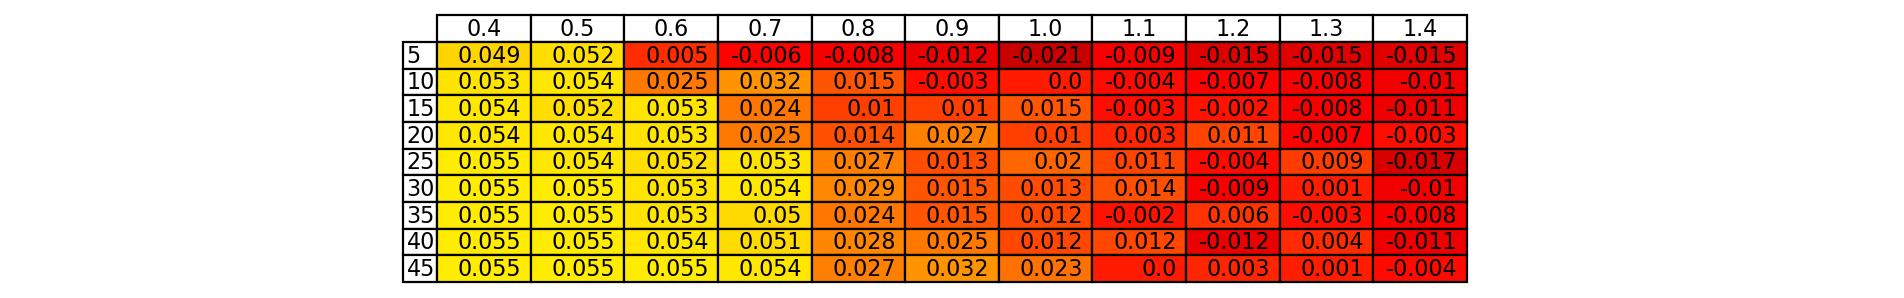

In [28]:
# Make a colored table with the silhouette scores
piv_sil = results_df.pivot(index='KNN', columns='resolution', values='sil')
vals = np.around(piv_sil.values,3) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-0.05, vals.max()+0.05)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_sil.index, colLabels=piv_sil.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)
plt.show()

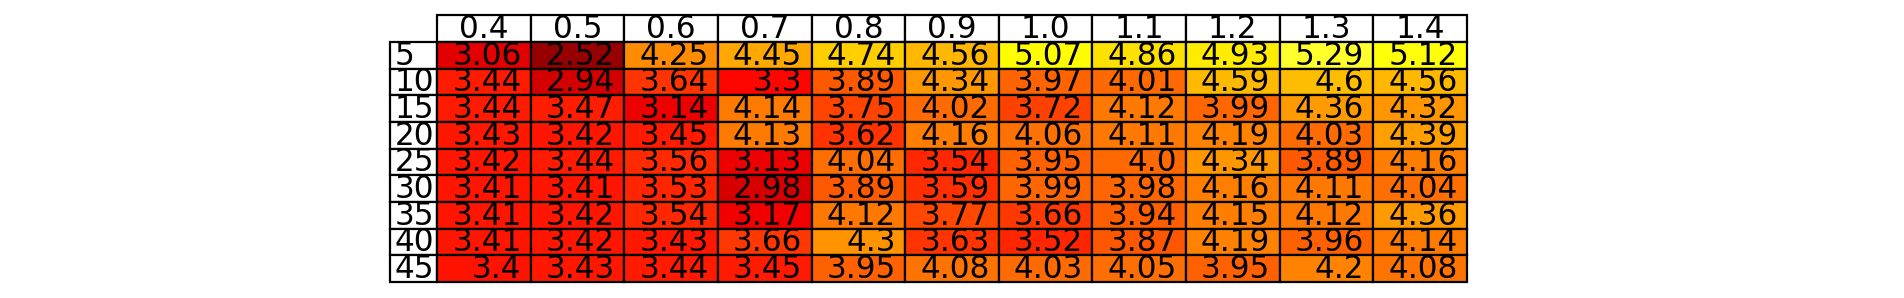

In [29]:
# Make a colored table with the Davies Bouldin scores
piv_DB = results_df.pivot(index='KNN', columns='resolution', values='davie_bould')

vals = np.around(piv_DB.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_DB.index, colLabels=piv_DB.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

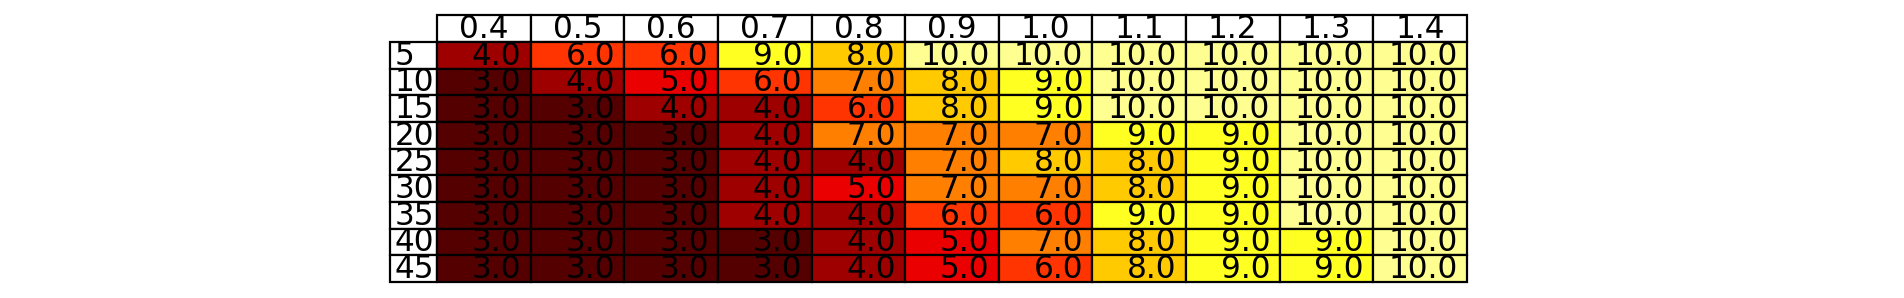

In [30]:
# Make a colored table with the number of clusters
piv_clust = results_df.pivot(index='KNN', columns='resolution', values='number_of_clusters')

vals = np.around(piv_clust.values,2) #evenly round to the given number of decimals.

norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(411, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=piv_clust.index, colLabels=piv_clust.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=colours)


plt.show()

In [31]:
max_sil = results_df[results_df.groupby('number_of_clusters')['sil'].transform('max') == results_df['sil']].sort_values(by=['number_of_clusters'])
max_sil

KNN  resolution  number_of_clusters       sil  davie_bould
0  25         0.4                 3.0  0.055296     3.418861
0  10         0.5                 4.0  0.054361     2.938122
0  45         0.9                 5.0  0.032488     4.076124
0   5         0.5                 6.0  0.051691     2.523056
0  20         0.9                 7.0  0.026562     4.155220
0  25         1.0                 8.0  0.019739     3.945508
0  15         1.0                 9.0  0.014868     3.715235
0  25         1.3                10.0  0.008790     3.894016

plot the maximum values for Silhouette score and minimum values from Davies-Bouldin index

In [32]:
min_db = results_df[results_df.groupby('number_of_clusters')['davie_bould'].transform('min') == results_df['davie_bould']].sort_values(by=['number_of_clusters'])
min_db

KNN  resolution  number_of_clusters       sil  davie_bould
0  45         0.4                 3.0  0.055262     3.399084
0  10         0.5                 4.0  0.054361     2.938122
0  40         0.9                 5.0  0.025115     3.630864
0   5         0.5                 6.0  0.051691     2.523056
0  40         1.0                 7.0  0.012287     3.520235
0  40         1.1                 8.0  0.011754     3.873504
0  15         1.0                 9.0  0.014868     3.715235
0  25         1.3                10.0  0.008790     3.894016

<function matplotlib.pyplot.show(*args, **kw)>

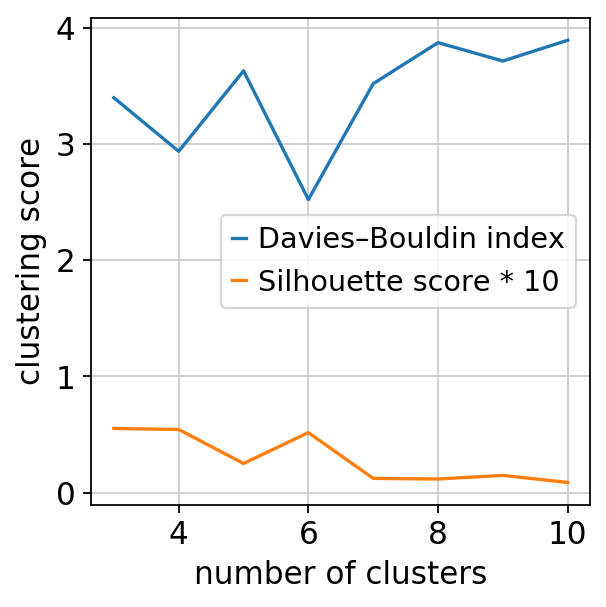

In [33]:
# plot the top value for each cluster

plt.plot(min_db['number_of_clusters'], min_db['davie_bould'])
plt.plot(max_sil['number_of_clusters'], min_db['sil'] * 10)
plt.legend(['Davies–Bouldin index','Silhouette score * 10'])
plt.xlabel('number of clusters')
plt.ylabel('clustering score')
plt.show

plot the maximum values for Silhouette score and minimum values from Davies-Bouldin index for specific clusters

In [34]:
results_df[results_df['number_of_clusters'] == 6].sort_values('davie_bould', ascending=True) 

KNN  resolution  number_of_clusters       sil  davie_bould
0   5         0.5                 6.0  0.051691     2.523056
0  10         0.7                 6.0  0.032453     3.299920
0  35         1.0                 6.0  0.011590     3.663908
0  15         0.8                 6.0  0.010486     3.753299
0  35         0.9                 6.0  0.015494     3.771488
0  45         1.0                 6.0  0.023083     4.031716
0   5         0.6                 6.0  0.004607     4.248442

In [35]:
results_df[results_df['number_of_clusters'] == 5].sort_values('sil', ascending=False) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  45         0.9                 5.0  0.032488     4.076124
0  30         0.8                 5.0  0.028976     3.887852
0  40         0.9                 5.0  0.025115     3.630864
0  10         0.6                 5.0  0.024631     3.644763

In [36]:
results_df[results_df['number_of_clusters'] == 4].sort_values('sil', ascending=False) 

KNN  resolution  number_of_clusters       sil  davie_bould
0  10         0.5                 4.0  0.054361     2.938122
0  30         0.7                 4.0  0.053992     2.983181
0  15         0.6                 4.0  0.053357     3.143407
0  25         0.7                 4.0  0.053019     3.127914
0  35         0.7                 4.0  0.050425     3.167246
0   5         0.4                 4.0  0.049316     3.061474
0  40         0.8                 4.0  0.027797     4.301311
0  45         0.8                 4.0  0.027279     3.953622
0  25         0.8                 4.0  0.026887     4.039086
0  20         0.7                 4.0  0.024807     4.127450
0  15         0.7                 4.0  0.023742     4.141638
0  35         0.8                 4.0  0.023624     4.122176

## plot different KNN + resolutions and see how the UMAP graphs actually look like

#### Leiden 4 clusters 35 KNN, 0.7 resolution

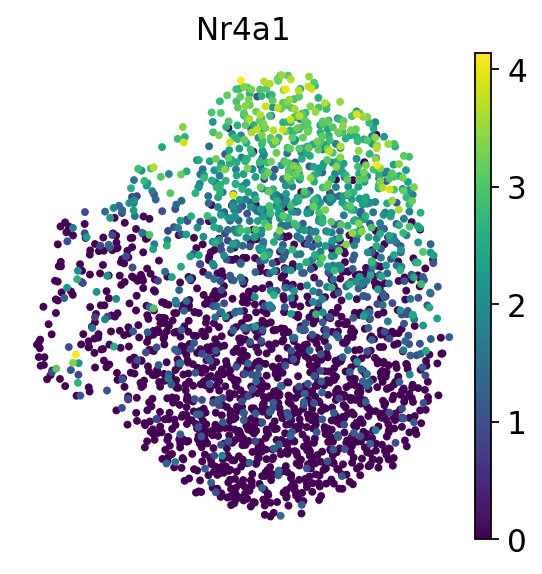

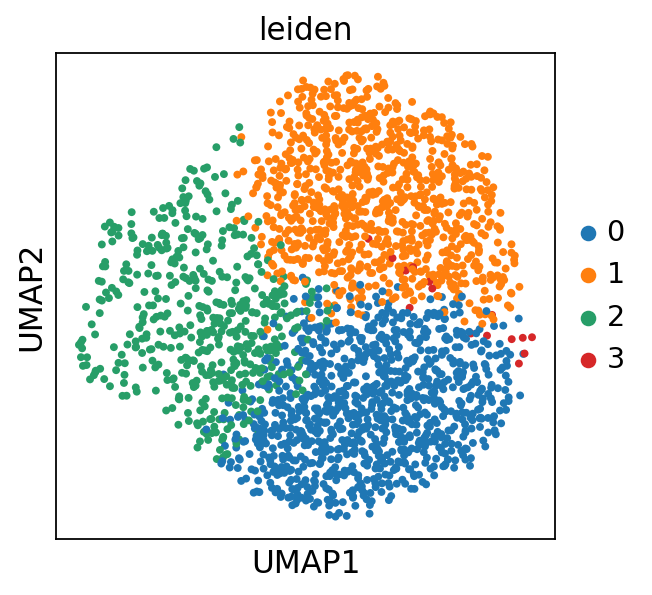

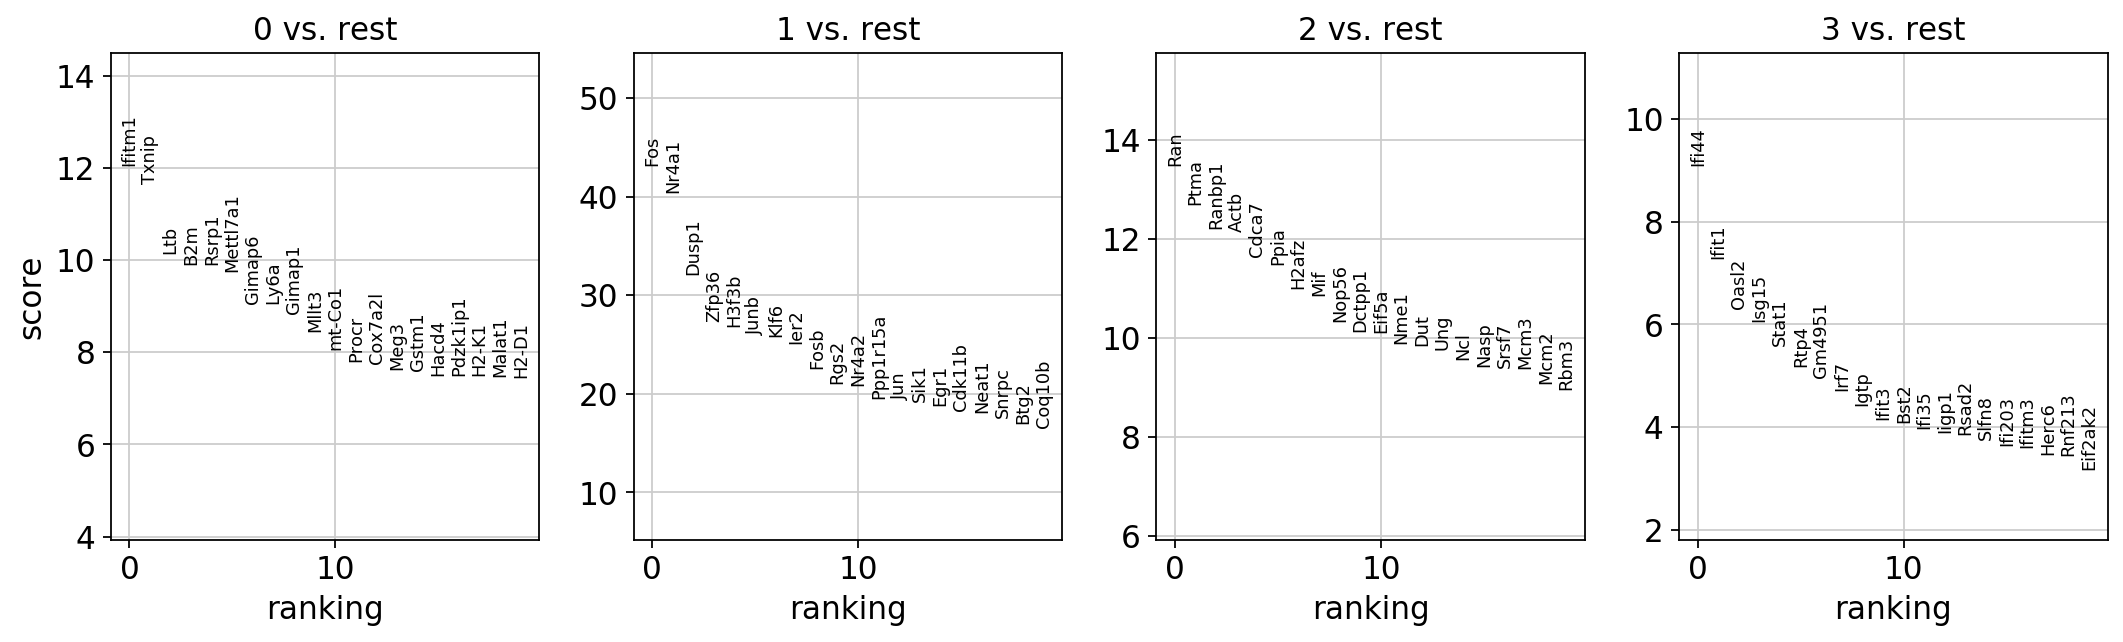

In [37]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=35, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

#### Leiden 5 clusters 5 KNN, 0.5 resolution

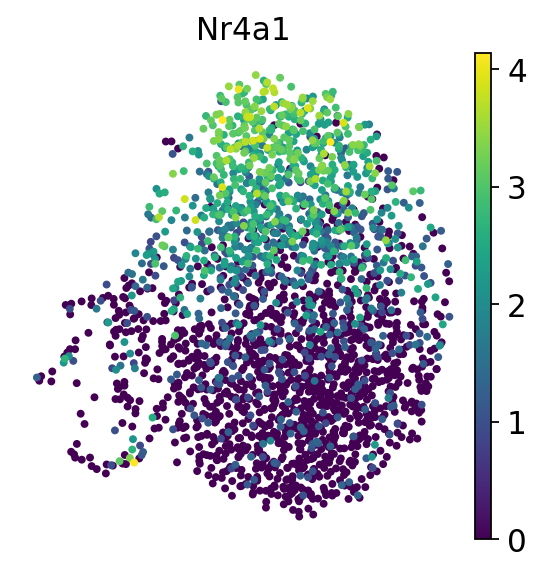

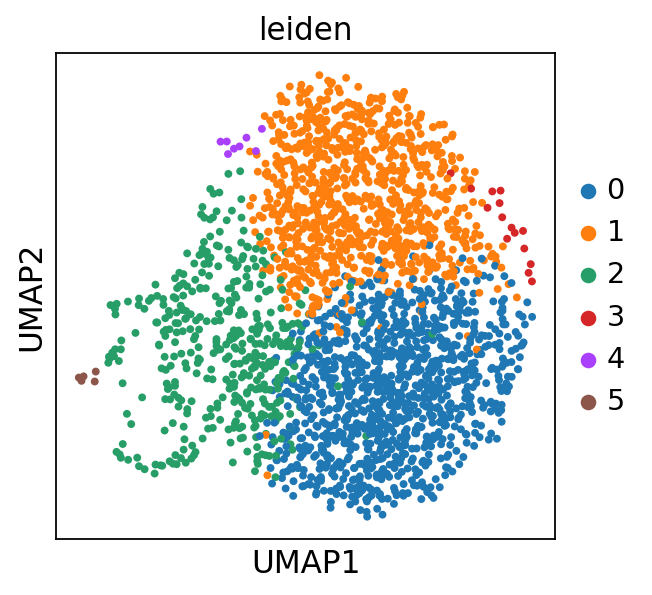

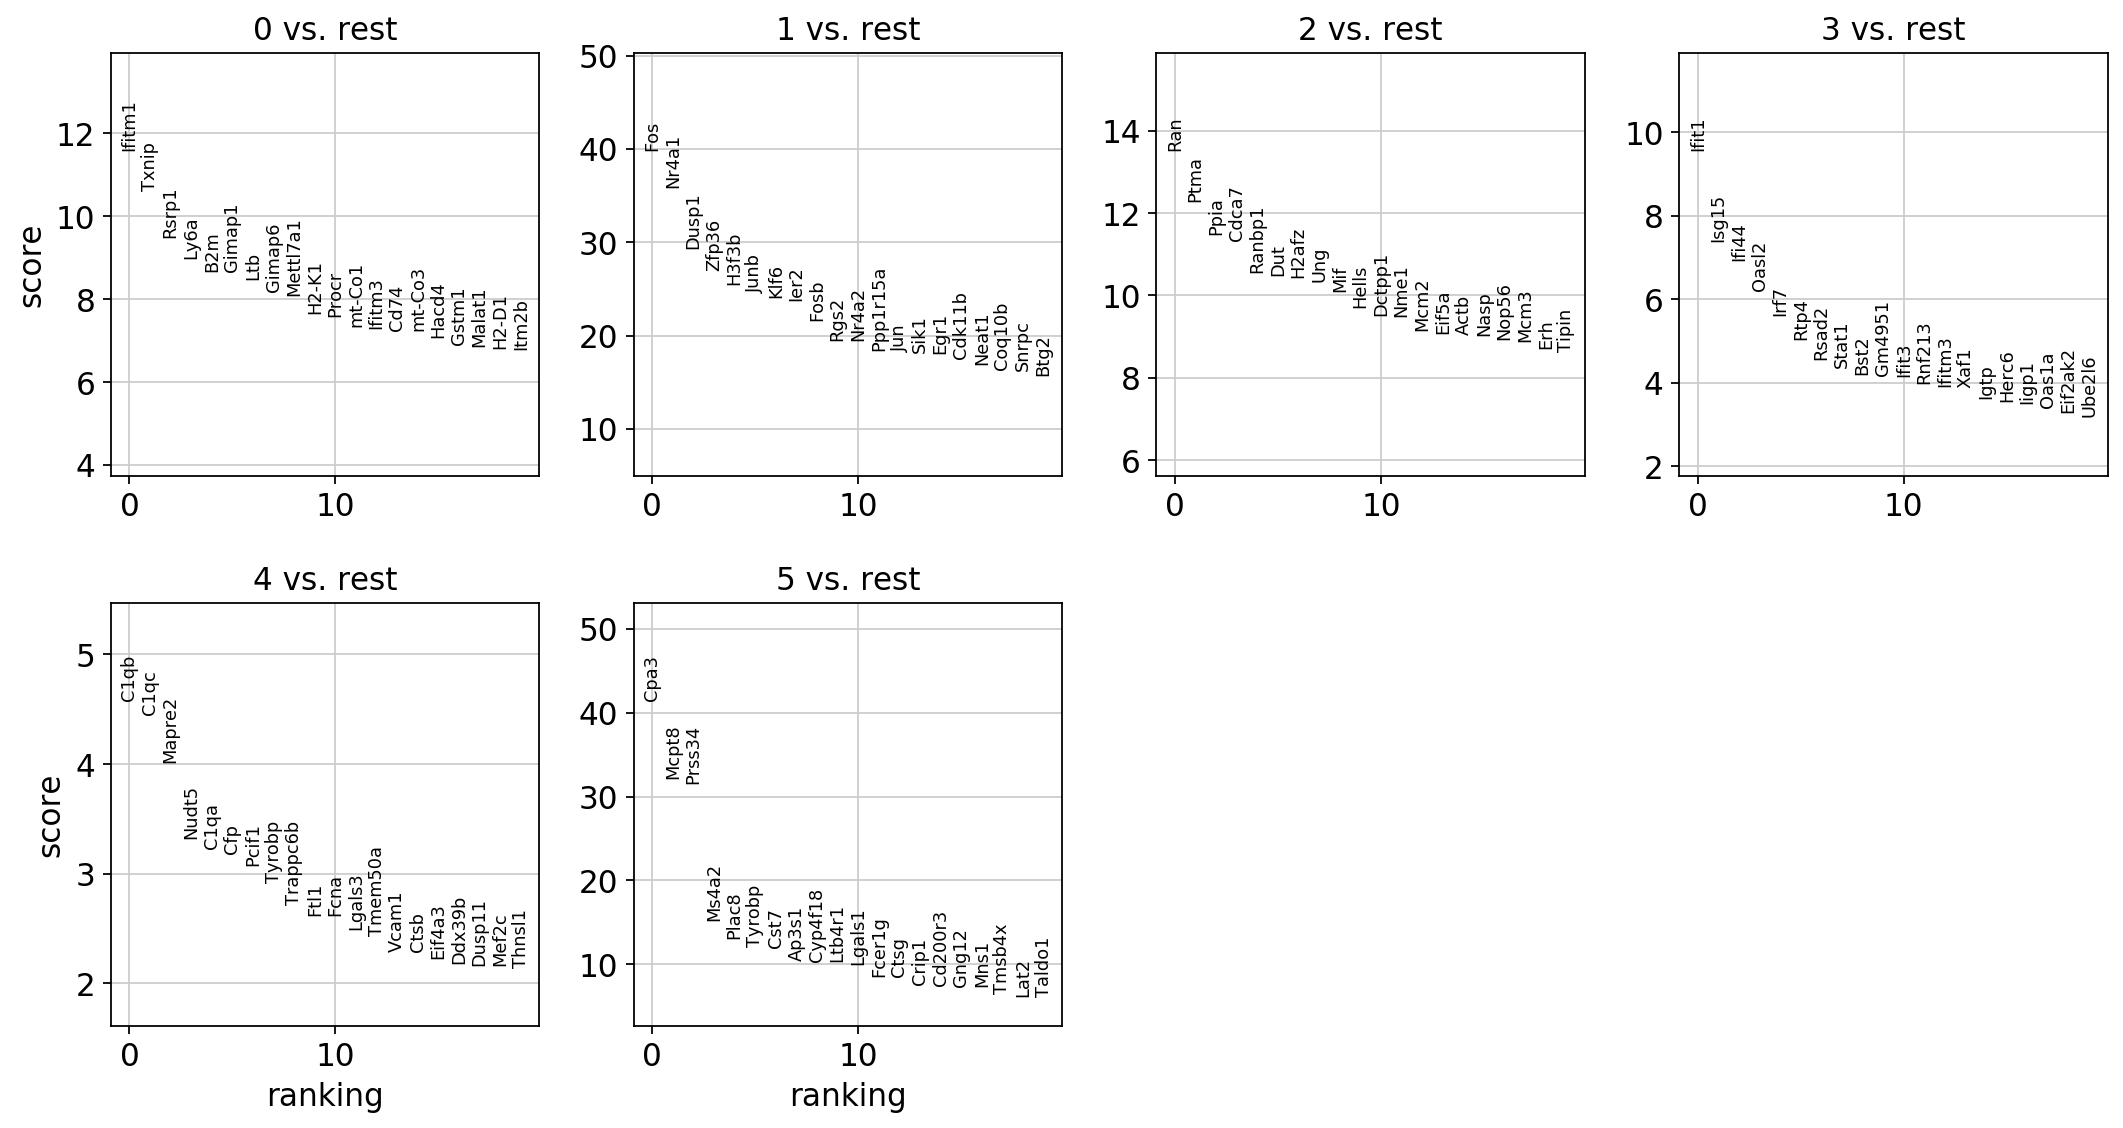

In [38]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

cluster 4 is really small

### Leiden 6 clusters 15 KNN, 0.7 resolution

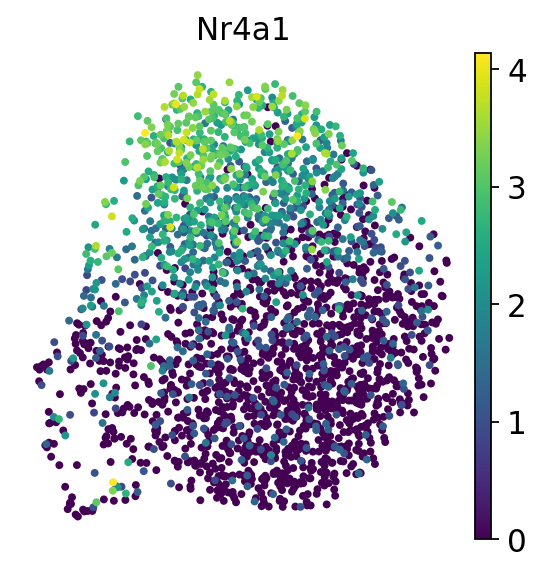

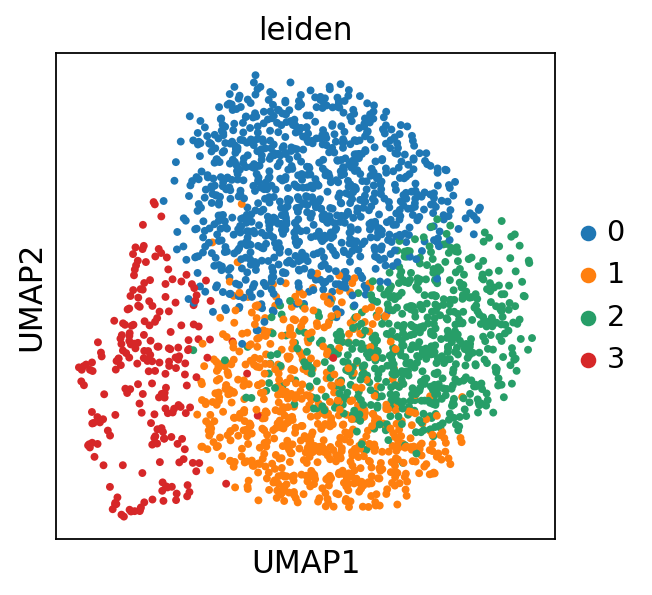

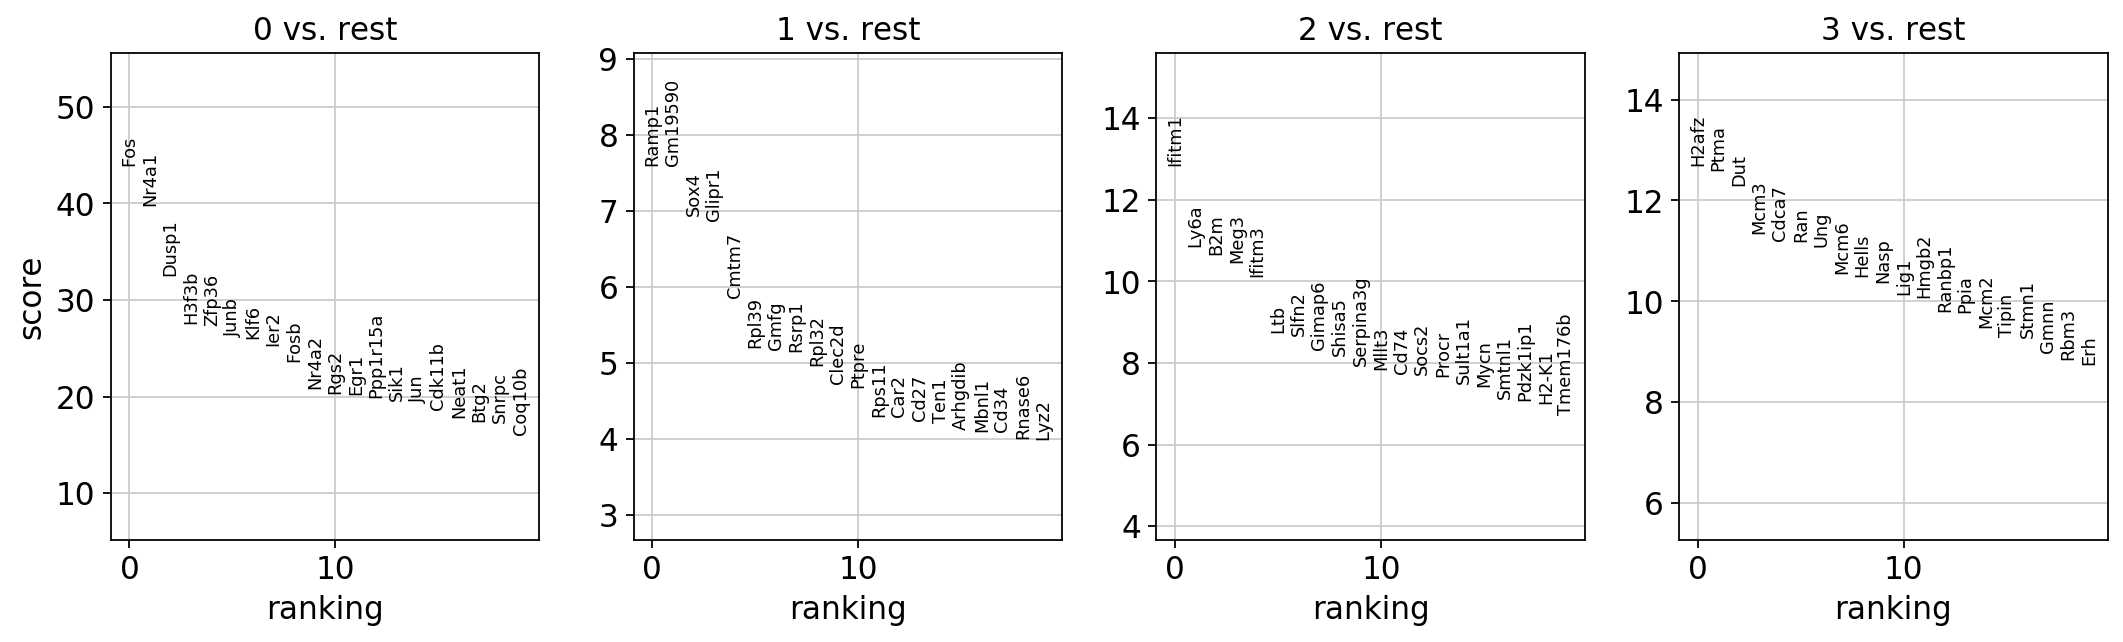

In [39]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

### 7) Move forward with cluster combination

#### Leiden 4 clusters 35 KNN, 0.7 resolution¶

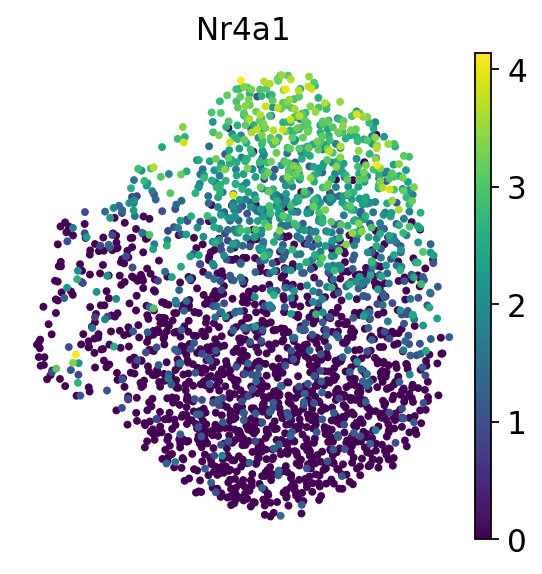

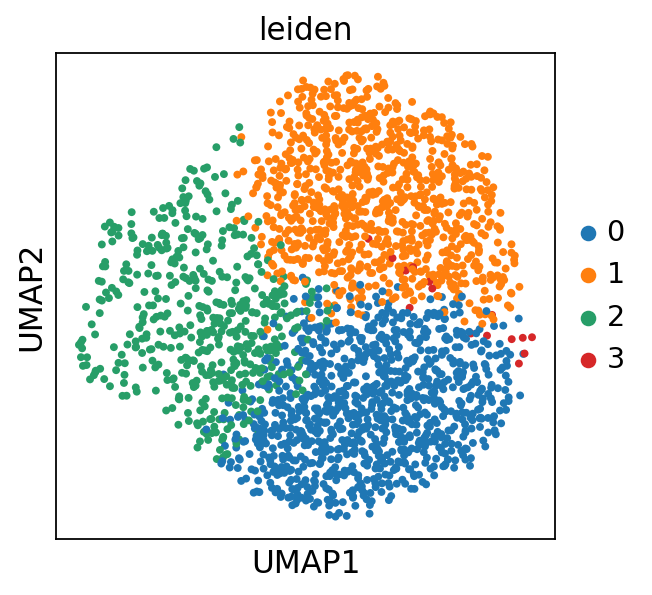

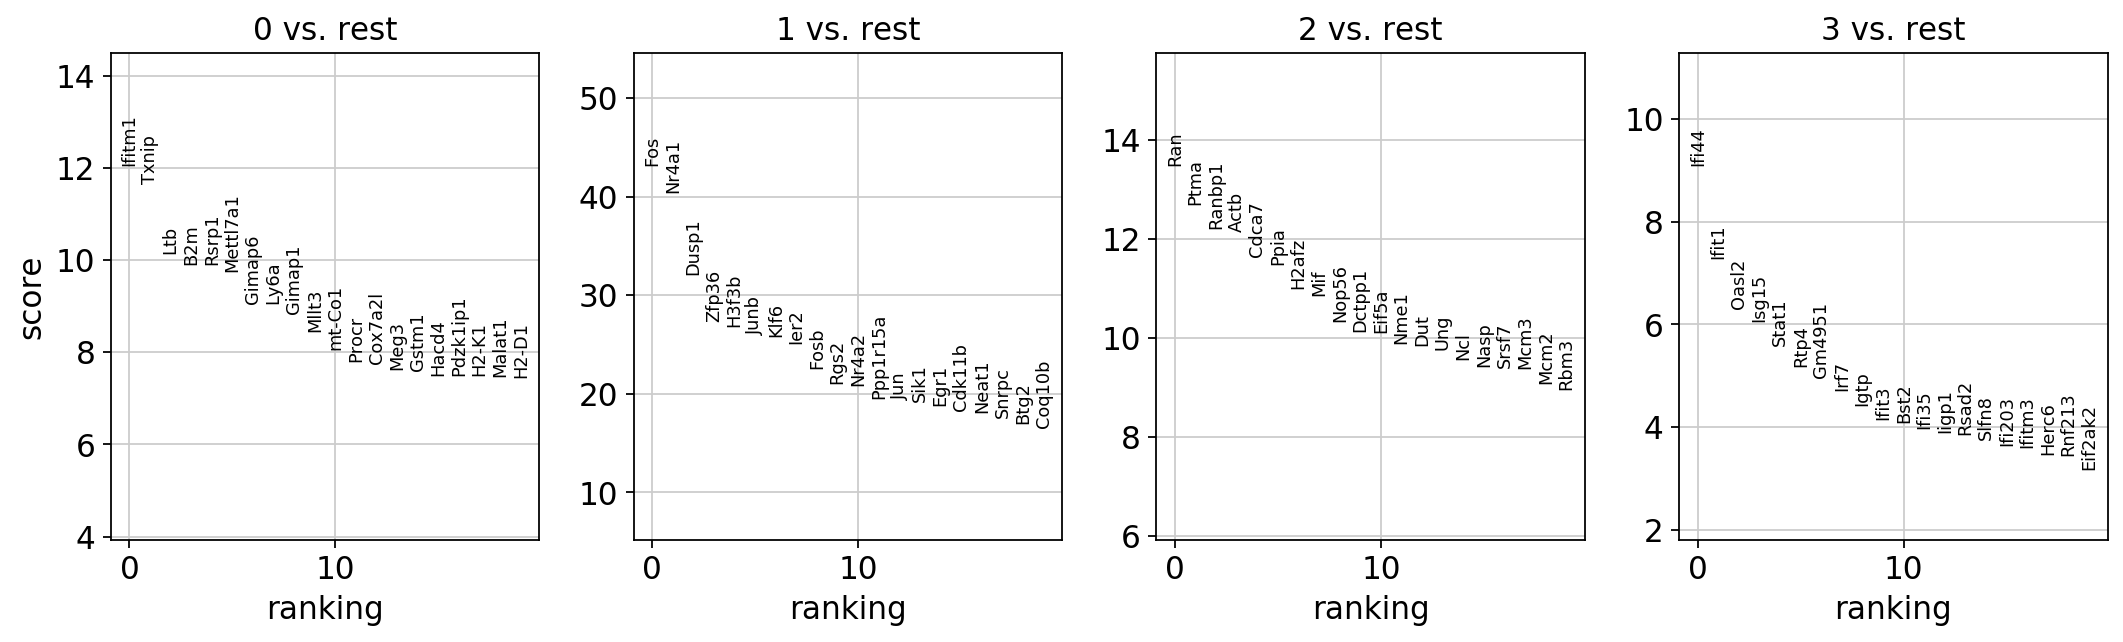

In [40]:
# redo the umap with different neigborhoods

sc.pp.neighbors(adata, n_neighbors=35, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Nr4a1'], legend_loc='on data', frameon=False)
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(adata, color=['leiden'])
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [41]:
# rename cluster categories
adata.rename_categories('leiden', ['Quiescent', 'Activated', 'Metabolism', 'Interferon'])

In [42]:
adata.uns['leiden_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#aa40fc', '#d62728', '#8c564b']

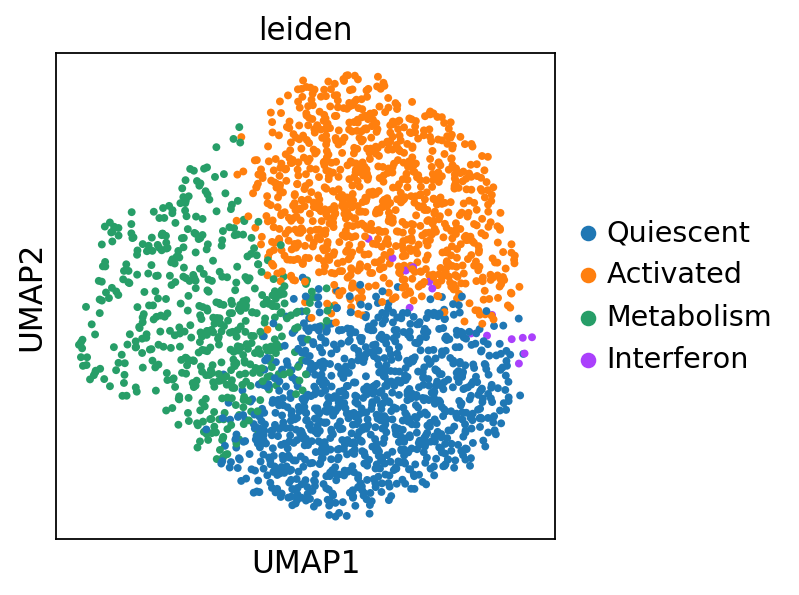

In [43]:
sc.pl.umap(adata, color='leiden', frameon=True, save='_old_LT.pdf')

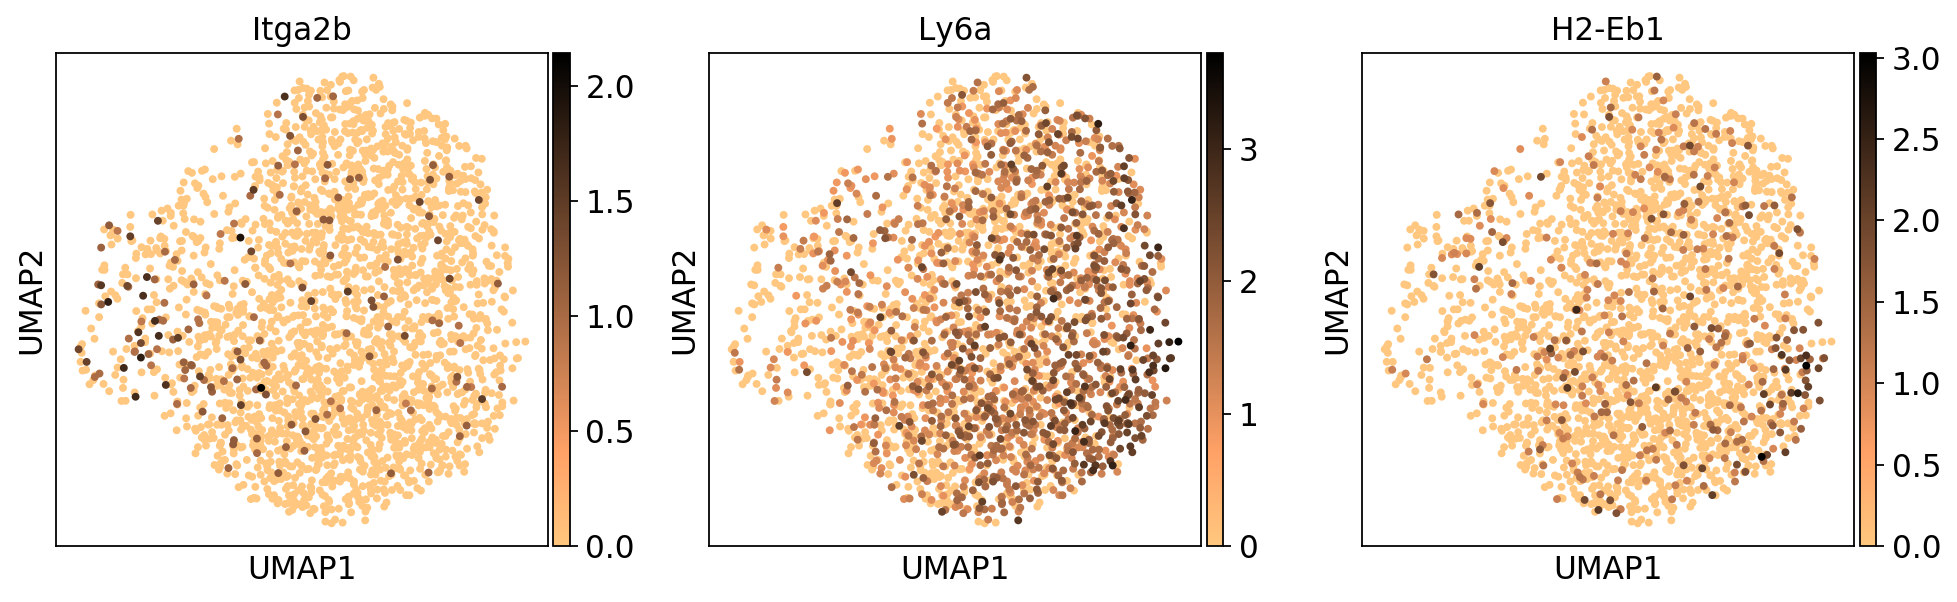

In [44]:
sc.pl.umap(adata, color = ['Itga2b', 'Ly6a', 'H2-Eb1'], cmap = 'copper_r', save='_old_LT_Itga2b_Ly6a_H2-Eb1.pdf')

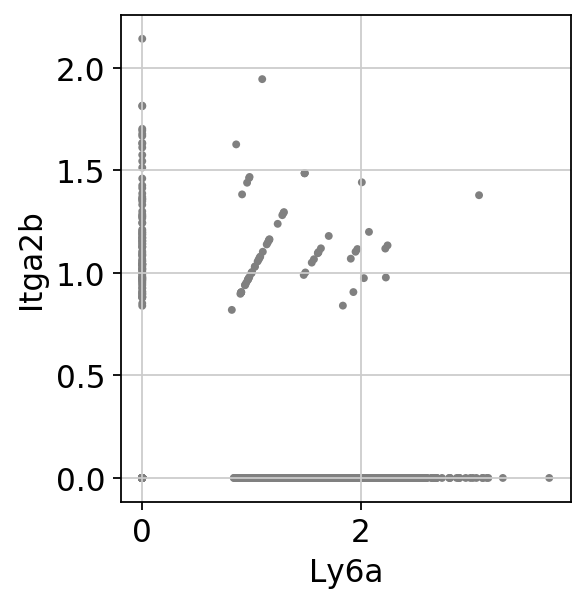

In [45]:
sc.pl.scatter(adata, x='Ly6a', y='Itga2b', save = '_old_LT_scatter_Itga2b_Ly6a.pdf')

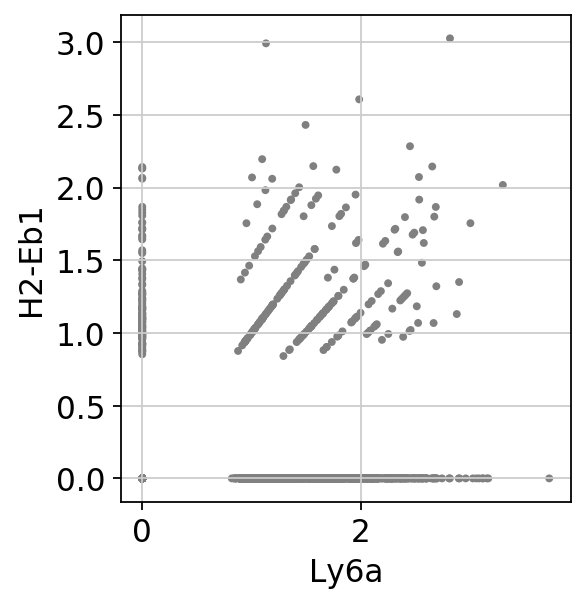

In [46]:
sc.pl.scatter(adata, x='Ly6a', y='H2-Eb1', save = '_old_LT_scatter_Itga2b_H2-Eb1.pdf')

In [47]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']})
#.head(5)

In [48]:
enrichment_clusters

Quiescent_n  Quiescent_s Activated_n  Activated_s Metabolism_n  \
0       Ifitm1    12.053443         Fos    43.154907          Ran   
1        Txnip    11.644235       Nr4a1    40.405636         Ptma   
2          Ltb    10.128781       Dusp1    32.103840       Ranbp1   
3          B2m     9.902033       Zfp36    27.303663         Actb   
4        Rsrp1     9.900495       H3f3b    26.812187        Cdca7   
..         ...          ...         ...          ...          ...   
95      Rabac1     3.986369        Dpm1     5.414113       Chchd2   
96       Rpl19     3.983870        Ftl1     5.345505         Pgls   
97       Ifi47     3.958037       Arpc3     5.325624      Hnrnpa1   
98     Tmem63b     3.947126        Atf4     5.249719          Tkt   
99    AW112010     3.933891        Rgcc     5.227470         Nkg7   

    Metabolism_s Interferon_n  Interferon_s  
0      13.484201        Ifi44      9.094761  
1      12.692476        Ifit1      7.284892  
2      12.207067        Oasl2      6.306534  
3      12.151029        Isg15      6.053075  
4      11.639833        Stat1      5.587022  
..           ...          ...           ...  
95      5.953577        Zufsp      1.836767  
96      5.951105         Il27      1.827309  
97      5.950543      Gpatch8      1.822311  
98      5.931892       H2-T22      1.815005  
99      5.922397        Zfp85      1.811797  

[100 rows x 8 columns]

In [49]:
enrichment_clusters.to_csv('./write/old_LT_clusters.csv', index=False, header=True)

In [50]:
# for export

enrichment_clusters = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj', 'logfoldchanges']})

enrichment_clusters.to_csv('./write/all_old_LT_clusters_names.csv', index=False, header=True)

In [51]:
# Annotate the data sets
print(adata.obs['leiden'].value_counts())
print('')

Quiescent     960
Activated     898
Metabolism    509
Interferon     15
Name: leiden, dtype: int64



In [52]:
# have to delete that otherwise there is a bug in the saving to .h5ad
adata.uns['rank_genes_groups'] = None
adata.uns['rank_genes'] = None

In [53]:
# write the file to disk
adata.write('./sc_objects/old_LT_preprocessed.h5ad')

In [54]:
cell_numbers = pd.DataFrame(adata.obs['leiden'].value_counts())

In [55]:
cell_numbers.to_csv('./write/old_LT_cell_numbers.csv', index=True, header=True)

In [56]:
sc.logging.print_versions()
pd.show_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1.post1

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : 1.2.8
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          :